In [1]:
import os
import sys
import time
import itertools
import numpy as np

# Torch
import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
print("Torch Version:", torch.__version__)

sys.path.append("../../")

# Planning
sys.path.append("../Planning/")
import Planners as Planners

# Control
sys.path.append("../Acting/")
import TrajectorySamplers as TrajectorySamplers

# Model
sys.path.append("../Learning/")
import Models as Models

# Simple RL
from simple_rl.tasks import NavigationWorldMDP
from simple_rl.tasks.navigation.NavigationWorldMDP import *
from simple_rl.tasks.navigation.NavigationStateClass import NavigationWorldState
from simple_rl.mdp.StateClass import State

# IRL
sys.path.append("../MLIRL")
from MLIRL import MLIRL

# MaxEnt
sys.path.append("../MaxEntIRL")
from MaxEntIRL import *

# Eval
sys.path.append("../utils/")
from Evaluation import *

import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable
# style.use('classic')
%matplotlib inline

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 55

%matplotlib inline
%load_ext autoreload
%autoreload 2

Torch Version: 0.5.0a0+ab6afc2


In [2]:
class IntState(State):
    ''' Class for Grid World States '''

    def __init__(self, x):
        State.__init__(self, data=x)
        self.x = round(x, 10)

    def __hash__(self):
        return hash(self.data)

    def __str__(self):
        return "s: (" + str(self.x) + ")"

    def __repr__(self):
        return self.__str__()

    def __eq__(self, other):
        return isinstance(other, IntState) and self.x == other.x

## SVF

In [3]:
# TEST: I/P: trajectory that toggles beween two states. O/P: SVF should approximate uniform distribution.
n_traj = 100
traj_len = 10000
S = [(0,0),(1,1)]
trajectory_list = [[(S[np.random.randint(0, len(S))],0) for j in range(traj_len)] for i in range(n_traj)]
assert np.linalg.norm(compute_svf(trajectory_list, S)-[0.5,0.5]) < 0.01

In [4]:
# TEST: I/P: trajectory that stays in one state. O/P: SVF should have all mass on that state.
n_traj = 100
traj_len = 10000
S = [(0,0),(1,1)]
trajectory_list = [[(S[0],0) for j in range(traj_len)] for i in range(n_traj)]
assert np.linalg.norm(compute_svf(trajectory_list, S)-[1.,0]) < 1e-7

In [5]:
# TEST: I/P: trajectory that stays in another state. O/P: SVF should have all mass on that state.
n_traj = 100
traj_len = 10000
S = [(0,0),(1,1)]
trajectory_list = [[(S[1],0) for j in range(traj_len)] for i in range(n_traj)]
assert np.linalg.norm(compute_svf(trajectory_list, S)-[0,1.]) < 1e-7

In [6]:
# TEST: I/P: trajectory that toggles between 3 states. O/P: SVF should approximate uniform distribution.
n_traj = 100
traj_len = 1000
S = [(0,0),(1,1),(2,2)] #list(np.random.randint(0,2,(1000,2)))
trajectory_list = [[(S[np.random.randint(0, len(S))],0) for j in range(traj_len)] for i in range(n_traj)]
assert np.linalg.norm(compute_svf(trajectory_list, S)-[0.33,0.33,0.33]) < 0.01

In [7]:
# TEST: I/P: trajectory that toggles between 2 of the states. O/P: SVF should approximate uniform distribution 
# on those 2 states and 0 mass on unvisited state.
n_traj = 100
traj_len = 1000
S = [(0,0),(1,1),(2,2)] #list(np.random.randint(0,2,(1000,2)))
trajectory_list = [[(S[np.random.choice([0,2])],0) for j in range(traj_len)] for i in range(n_traj)]
assert np.linalg.norm(compute_svf(trajectory_list, S)-[0.5,0,0.5]) < 0.01

## Expected SVF

In [8]:
"""
TEST
I/P: 2 state MDP with Policy that stays in state 2.
O/P: Expected SVF with all mass on state 2.
"""
S = [IntState(s) for s in [1,2]] # S1, S2
A = ["stay", "move"]

T_dict = {S[0]: {"stay": [(S[0], 1.)], "move": [(S[1], 1.)]},
             S[1]:{"stay": [(S[1], 1.)], "move": [(S[0], 1.)]}}

def T(s,a): return T_dict[s][a]
trajectory_list = [list(zip(np.random.choice([S[1]], 10), np.random.choice(["stay", "move"], 10))) 
                   for i in range(100)] # data doesn't matter for expected SVF, it's only used for determining N.
# Policy: stay in S2
Pi = np.array(
      [[0,1], # Pi[S1]
      [1,0]] # Pi[S2]
)
assert np.linalg.norm(compute_expected_svf(trajectory_list, S, A, Pi, T) - [0,1]) < 1e-8

In [9]:
"""
TEST
I/P: 2 state MDP with Policy that toggles between 2 states.
O/P: Expected SVF should approxiamte uniform distribution.
"""
S = [IntState(s) for s in [1,2]] # S1, S2
A = ["stay", "move"]

T_dict = {S[0]: {"stay": [(S[0], 1.)], "move": [(S[1], 1.)]},
             S[1]:{"stay": [(S[1], 1.)], "move": [(S[0], 1.)]}}
def T(s,a): return T_dict[s][a]
trajectory_list = [list(zip(np.random.choice([S[0],S[1]], 10), np.random.choice(["stay", "move"], 10)))
                   for i in range(100)] # data doesn't matter for expected SVF, it's only used for determining N.
# Policy: keep jumping between S1 and S2
Pi = np.array(
      [[0,1], # Pi[S1]
      [0,1]] # Pi[S2]
)
assert np.linalg.norm(compute_expected_svf(trajectory_list, S, A, Pi, T) - [0.5,0.5]) < 1e-5

## MaxEnt IRL

In [10]:
# MDP
S = [IntState(s) for s in [1,2,3,4]] # S1, S2
A = ["stay", "move"]

T_dict = {S[0]: 
              {"stay": [(S[0], 1.0)], 
               "move": [(S[1], 1.0)]},
          S[1]:
              {"stay": [(S[1], 1.0)], 
               "move": [(S[3], 1.0)]},
          S[2]:
              {"stay": [(S[2], 1.0)], 
               "move": [(S[3], 1.0)]},
          S[3]:
              {"stay": [(S[3], 1.0)],
               "move": [(S[3], 1.0)]},
         }
def T(s,a): return T_dict[s][a]
trajectory_list = [[(S[0], "move"), (S[1], "move"), (S[3], "stay")], 
                   [(S[0], "move"), (S[2], "move"), (S[3], "stay")]
                  ]
# Params
gamma = 0.99

# Features
phi_dict = {S[0]: [0,0,0,1],
            S[1]: [0,0,1,0],
            S[2]: [0,1,0,0],
            S[3]: [1,0,0,0]}
phi = lambda s: torch.FloatTensor(phi_dict[s])
phi_dim = len(phi(S[0]))

# Reward Model
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, mean=-1, std=0.01)
R_model = Models.LinearRewardModel_ReLU(phi_dim, 0)
R_model.apply(weights_init)

# Optimizer
lr, weight_decay = 0.1, 1e-2
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)

In [11]:
maxent_loss_history, learned_policies, _, _ = MaxEntIRL(trajectory_list, lambda _: S, lambda _: T, A, phi, R_model, R_optimizer, gamma, 
                                                  verbose=True, debug=True, n_iters=100, boltzmann_temp=1.)

MaxEntIRL params 
-----
	 Domains: 2, sizes: [4, 4],
	 Action dim: 2, 
	 Feature dim: 4,
	 Iterations: 100, 
	 Max likelihood: 0.99,
	 VI iterations: 100, 
	 VI convergence eps: 0.001,
	 Gamma (discount factor): 0.99,
--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass didn't converge by 100.
Backward Pass Results: 
	Policy: [[0.93902075 0.06097929]
 [0.9660942  0.03390587]
 [0.9660942  0.03390587]
 [0.5        0.5       ]], 
	V: [6.146894 3.384167 3.384167 0.      ], 
	Q: [[6.0839763 3.349673 ]
 [3.349673  0.       ]
 [3.349673  0.       ]
 [0.        0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [9.4026023e-01 5.9050620e-02 0.0000000e+00 6.8918540e-04] 
	Diff: tensor([-0.6069,  0.1076,  0.1667,  0.3326]) 

Grads: 
	Param: 0, grad: tensor([[0., 0., 0., 0.]])

>>> Iter: 0007 (0.024s): loss = 00.303463, likelihood = 0.0000


--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass didn't converge by 100.
Backward Pass Results: 
	Policy: [[0.93902075 0.06097929]
 [0.9660942  0.03390587]
 [0.9660942  0.03390587]
 [0.5        0.5       ]], 
	V: [6.146894 3.384167 3.384167 0.      ], 
	Q: [[6.0839763 3.349673 ]
 [3.349673  0.       ]
 [3.349673  0.       ]
 [0.      

Running Backward Pass  [ ... ] Backward pass converged @ 94.
Backward Pass Results: 
	Policy: [[0.7489436  0.25105628]
 [0.9659436  0.03405649]
 [0.9659436  0.03405649]
 [0.5        0.5       ]], 
	V: [4.4838977 3.3797348 3.3797348 0.       ], 
	Q: [[4.194806  3.1018195]
 [3.345085  0.       ]
 [3.345085  0.       ]
 [0.        0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.7699534  0.2271965  0.         0.00285003] 
	Diff: tensor([-0.4366, -0.0605,  0.1667,  0.3305]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.8732]])

>>> Iter: 0015 (0.029s): loss = 00.248575, likelihood = 0.0001


--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-0.3264, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <func

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.501322   0.49149433 0.         0.00718367] 
	Diff: tensor([-0.1680, -0.3248,  0.1667,  0.3261]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.3360]])

>>> Iter: 0023 (0.029s): loss = 00.246408, likelihood = 0.0005


--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-1.0585, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.33741733 0.6625827 ]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [2.696383  3.3779728 3.3779728 0.       ], 
	Q: [[1.6099483 2.284773 ]
 [3.3432608 0.       ]
 [3.3432608 0.       ]
 

--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-1.6702, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.18453893 0.81546104]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [1.8771119 3.3779728 3.3779728 0.       ], 
	Q: [[0.1872171 1.6731102]
 [3.3432608 0.       ]
 [3.3432608 0.       ]
 [0.        0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.40619788 0.58452857 0.         0.00927357] 
	Diff: tensor([-0.0729, -0.4179,  0.1667,  0.3241]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.0729]])
------------------------------------------

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.12667157 0.87332845]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [1.427795  3.3779728 3.3779728 0.       ], 
	Q: [[-0.6383625  1.2923515]
 [ 3.3432608  0.       ]
 [ 3.3432608  0.       ]
 [ 0.         0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.38090575 0.6091626  0.         0.00993165] 
	Diff: tensor([-0.0476, -0.4425,  0.1667,  0.3234]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.0951]])

>>> Iter: 0039 (0.025s): loss = 00.245034, likelihood = 0.0009


--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.0950, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.3678504  0.6218533  0.         0.01029635] 
	Diff: tensor([-0.0345, -0.4552,  0.1667,  0.3230]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.0690]])

>>> Iter: 0047 (0.029s): loss = 00.244852, likelihood = 0.0010


--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.3750, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.0919386  0.9080614 ]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [1.0646855 3.3779728 3.3779728 0.       ], 
	Q: [[-1.3219488   0.96824217]
 [ 3.3432608   0.        ]
 [ 3.3432608   0

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.07661712 0.92338294]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [0.8636418 3.3779728 3.3779728 0.       ], 
	Q: [[-1.7052929   0.78393054]
 [ 3.3432608   0.        ]
 [ 3.3432608   0.        ]
 [ 0.          0.        ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.36082911 0.62867004 0.         0.01050088] 
	Diff: tensor([-0.0275, -0.4620,  0.1667,  0.3228]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.0275]])
--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.5593, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ .

--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.6838, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.06774122 0.9322588 ]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [0.7296092 3.3779728 3.3779728 0.       ], 
	Q: [[-1.9624512   0.65946436]
 [ 3.3432608   0.        ]
 [ 3.3432608   0.        ]
 [ 0.          0.        ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.35744333 0.63195485 0.         0.01060182] 
	Diff: tensor([-0.0241, -0.4653,  0.1667,  0.3227]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.0482]])

>>> Iter: 0064 (0.025s): 

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.35532713 0.63400716 0.         0.01066572] 
	Diff: tensor([-0.0220, -0.4673,  0.1667,  0.3227]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.0440]])

>>> Iter: 0072 (0.024s): loss = 00.244667, likelihood = 0.0010


--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.7804, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.06156515 0.93843484]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [0.6263744 3.3779728 3.3779728 0.       ], 
	Q: [[-2.161285   0.5628326]
 [ 3.3432608  0.       ]
 [ 3.3432608  0.    

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.3537477  0.6355385  0.         0.01071383] 
	Diff: tensor([-0.0204, -0.4689,  0.1667,  0.3226]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.0204]])
--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.8426, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.05789155 0.94210845]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [0.5602822 3.3779728 3.3779728 0.       ], 
	Q: [[-2.2889016  0.5006473]
 [ 3.3432608  0.       ]
 [ 3.3432608  0.       ]
 [ 0.         0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.35351646 0.46816984 0.         0.17831369] 
	Diff: tensor([-0.0202, -0.3015,  0.1667,  0.1550]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000, -0.6030, -0.0404]])

>>> Iter: 0089 (0.026s): loss = 00.160843, likelihood = 0.0172


--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.8965, grad_fn=<SelectBackward>), tensor(-1.0157, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 91.
Backward Pass Results: 
	Policy: [[0.05712483 0.9428753 ]
 [0.36419475 0.6358053 ]
 [0.96585125 0.03414869]
 [0.5        0.5       ]], 
	V: [-3.3948474 -0.5628318  3.377031   0.       ], 
	Q: [[-6.257364  -3.4536686]
 [-1.5728983 -1.0156947]
 [ 3.342285

Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.9367, grad_fn=<SelectBackward>), tensor(-2.4052, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 91.
Backward Pass Results: 
	Policy: [[0.05585011 0.9441499 ]
 [0.09235062 0.9076494 ]
 [0.96585125 0.03414869]
 [0.5        0.5       ]], 
	V: [-5.1645246 -2.3083494  3.377031   0.       ], 
	Q: [[-8.049608  -5.221995 ]
 [-4.690512  -2.4052465]
 [ 3.3422856  0.       ]
 [ 0.         0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.3529898  0.3613579  0.         0.28565237] 
	Diff: tensor([-0.0197, -0.1947,  0.1667,  0.0477]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000, -0.1947, -0.0197]])
--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [

Text(0.5,0,'Iterations')

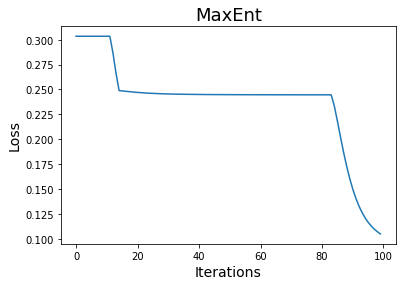

In [12]:
plt.plot(maxent_loss_history)
plt.title("MaxEnt")
plt.ylabel("Loss")
plt.xlabel("Iterations")

In [13]:
learned_policies[-1].round(2)

array([[0.06, 0.94],
       [0.08, 0.92],
       [0.97, 0.03],
       [0.5 , 0.5 ]], dtype=float32)

## BUG: Incorrect gradient specification

Phew.. The syntax of back-propagating MaxEnt gradient used was wrong. Instead of computing (dL / dR)*(dR / dtheta) for each state and adding them, the code was computing dL / dR over whole state space and the sum of such jacobian was being applied repeatedly for all states.

That is, desired operation was

$\frac{dL(s)}{d\theta} = \frac{dL(s)}{dR(s)} \frac{dR(s)}{d\theta} $

$\frac{dL}{d\theta} = \sum_s \frac{dL(s)}{d\theta}$


However, the implementation was doing

$\frac{dL(s)}{d\theta} = [\frac{dL(s_0)}{dR(s_0)}, \frac{dL(s_1)}{dR(s_1)}, ..., \frac{dL(s_n)}{dR(s_n)}] * \frac{dR(s)}{d\theta} $
$\frac{dL}{d\theta} = \sum_s \frac{dL(s)}{d\theta}$

The vector $[\frac{dL(s_0)}{dR(s_0)}, \frac{dL(s_1)}{dR(s_1)}, ..., \frac{dL(s_n)}{dR(s_n)}]$ automatically was being summed by PyTorch because it was one to many relationship. So gradients of reward over the whole states were equal, that led to no failure in parameter update.

## Scratchpad

In [14]:
R_model = Models.LinearRewardModel_ReLU(phi_dim, 0)
R_model.apply(weights_init)
R = [R_model(phi(s)).type(torch.float32)[0] for s in S] 

In [15]:
R[0].backward(gradient=torch.FloatTensor([-5.]))

In [16]:
R_model.w.weight.grad

tensor([[0., 0., 0., 0.]])

In [17]:
R_model = Models.LinearRewardModel_ReLU(phi_dim, 0)
R_model.apply(weights_init)
R = [R_model(phi(s)).type(torch.float32)[0] for s in S] 

In [18]:
R[0].backward(gradient=torch.FloatTensor([-5., -5., -5.]))

In [19]:
R_model.w.weight.grad

tensor([[0., 0., 0., 0.]])

In [20]:
R_model = Models.LinearRewardModel_ReLU(phi_dim, 0)
R_model.apply(weights_init)
R = [R_model(phi(s)).type(torch.float32)[0] for s in S] 

In [21]:
for r in R:
    r.backward(gradient=torch.FloatTensor([-5.]))

In [22]:
R_model.w.weight.grad

tensor([[0., 0., 0., 0.]])

In [23]:
R_model = Models.LinearRewardModel_ReLU(phi_dim, 0)
R_model.apply(weights_init)
R = [R_model(phi(s)).type(torch.float32)[0] for s in S] 

In [24]:
for r in R:
    r.backward(gradient=torch.FloatTensor([-1., -2, -3, -4]))

In [25]:
R_model.w.weight.grad

tensor([[0., 0., 0., 0.]])

## With Error

In [26]:
R_model = Models.LinearRewardModel_ReLU(phi_dim, 0)
R_model.apply(weights_init)

# Optimizer
lr, weight_decay = 0.1, 1e-2
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)

In [27]:
maxent_loss_history, learned_policies, _ , _ = MaxEntIRL(trajectory_list, lambda _: S, lambda _: T, A, phi, R_model, R_optimizer, gamma, 
                                                  verbose=True, debug=True, n_iters=100, boltzmann_temp=1.)

MaxEntIRL params 
-----
	 Domains: 2, sizes: [4, 4],
	 Action dim: 2, 
	 Feature dim: 4,
	 Iterations: 100, 
	 Max likelihood: 0.99,
	 VI iterations: 100, 
	 VI convergence eps: 0.001,
	 Gamma (discount factor): 0.99,
--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass didn't converge by 100.
Backward Pass Results: 
	Policy: [[0.93902075 0.06097929]
 [0.9660942  0.03390587]
 [0.9660942  0.03390587]
 [0.5        0.5       ]], 
	V: [6.146894 3.384167 3.384167 0.      ], 
	Q: [[6.0839763 3.349673 ]
 [3.349673  0.       ]
 [3.349673  0.       ]
 [0.        0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [9.4026023e-01 5.9050620e-02 0.0000000e+00 6.8918540e-04] 
	Diff: tensor([-0.6069,  0.1076,  0.1667,  0.3326]) 

Grads: 
	Param: 0, grad: tensor([[0., 0., 0., 0.]])
--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass didn't converge by 100.
Backward Pass Results: 
	Policy: [[0.93902075 0.06097929]
 [0.9660942  0.03390587]
 [0.9660942  0.03390587]
 [0.5        0.5       ]], 
	V: [6.146894 3.384167 3.384167 0.      ], 
	Q: [[6.0839763 3.349673 ]
 [3.349673  0.       ]
 [3.349673  0.       ]
 [0.        0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.166666

Running Backward Pass  [ ... ] Backward pass converged @ 94.
Backward Pass Results: 
	Policy: [[0.664496   0.33550385]
 [0.9659436  0.03405649]
 [0.9659436  0.03405649]
 [0.5        0.5       ]], 
	V: [4.070131  3.3797348 3.3797348 0.       ], 
	Q: [[3.6614044 2.978009 ]
 [3.345085  0.       ]
 [3.345085  0.       ]
 [0.        0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.702017   0.2941742  0.         0.00380869] 
	Diff: tensor([-0.3687, -0.1275,  0.1667,  0.3295]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.3687]])
--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-0.3671, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pa

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.32660446 0.67339563]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [2.647131  3.3779728 3.3779728 0.       ], 
	Q: [[1.5281255 2.2517087]
 [3.3432608 0.       ]
 [3.3432608 0.       ]
 [0.        0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.47775832 0.51458377 0.         0.00765798] 
	Diff: tensor([-0.1444, -0.3479,  0.1667,  0.3257]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.1444]])
--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-1.0916, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pa

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.18367095 0.816329  ]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [1.8712751 3.3779728 3.3779728 0.       ], 
	Q: [[0.1766656 1.6683372]
 [3.3432608 0.       ]
 [3.3432608 0.       ]
 [0.        0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.405802   0.5849145  0.         0.00928344] 
	Diff: tensor([-0.0725, -0.4182,  0.1667,  0.3240]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.1449]])

>>> Iter: 0032 (0.025s): loss = 00.245358, likelihood = 0.0008


--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-1.7345, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <func


>>> Iter: 0040 (0.025s): loss = 00.245015, likelihood = 0.0009


--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.1172, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.11863419 0.8813659 ]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [1.3523257 3.3779728 3.3779728 0.       ], 
	Q: [[-0.779385   1.2260432]
 [ 3.3432608  0.       ]
 [ 3.3432608  0.       ]
 [ 0.         0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.37756944 0.6124076  0.         0.01002305] 
	Diff: tensor([-0.0442, -0.4457,  0.1667,  0.3233]) 

Grads: 
	Param: 0, grad: tensor([[ 0.000

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.36695752 0.6227205  0.         0.01032202] 
	Diff: tensor([-0.0336, -0.4561,  0.1667,  0.3230]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.0336]])
--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.3706, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.09234488 0.9076551 ]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [1.0695914 3.3779728 3.3779728 0.       ], 
	Q: [[-1.3126335  0.9727006]
 [ 3.3432608  0.       ]
 [ 3.3432608  0.       ]
 [ 0.         0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.

--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.5221, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.07948761 0.9205124 ]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [0.90393937 3.3779728  3.3779728  0.        ], 
	Q: [[-1.6282146   0.82111454]
 [ 3.3432608   0.        ]
 [ 3.3432608   0.        ]
 [ 0.          0.        ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.3619353  0.62759644 0.         0.01046823] 
	Diff: tensor([-0.0286, -0.4609,  0.1667,  0.3229]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.0572]])

>>> Iter: 0056 (0.033

--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.6178, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.07231267 0.92768735]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [0.80053866 3.3779728  3.3779728  0.        ], 
	Q: [[-1.8262173  0.7254782]
 [ 3.3432608  0.       ]
 [ 3.3432608  0.       ]
 [ 0.         0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.3591806  0.6302696  0.         0.01054983] 
	Diff: tensor([-0.0258, -0.4636,  0.1667,  0.3228]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.0258]])
------------------------------

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.0236]])
--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.7026, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.06649587 0.9335042 ]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [0.709518  3.3779728 3.3779728 0.       ], 
	Q: [[-2.0010974  0.6407082]
 [ 3.3432608  0.       ]
 [ 3.3432608  0.       ]
 [ 0.         0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.35697255 0.63241154 0.         0.01061598] 
	Diff: tensor([-0.0236, -0.4657,  0.1667,  0.3227]) 

Grads: 
	Param: 0, grad: tensor([[

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.35523763 0.6335191  0.         0.01124331] 
	Diff: tensor([-0.0219, -0.4669,  0.1667,  0.3221]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000, -0.4669, -0.0219]])
--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.7759, grad_fn=<SelectBackward>), tensor(-0.0025, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 91.
Backward Pass Results: 
	Policy: [[0.06188332 0.9381167 ]
 [0.96404505 0.03595493]
 [0.96585125 0.03414869]
 [0.5        0.5       ]], 
	V: [0.5768941 3.3229449 3.377031  0.       ], 
	Q: [[-2.2056105e+00  5.1301318e-01]
 [ 3.2863276e+00 -2.5440627e-03]
 [ 3.3422856e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.35506    0.470747   0.         0.17419298] 
	Diff: tensor([-0.0217, -0.3041,  0.1667,  0.1591]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000, -0.6082, -0.0435]])

>>> Iter: 0083 (0.026s): loss = 00.162904, likelihood = 0.0167


--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.8268, grad_fn=<SelectBackward>), tensor(-0.9856, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 91.
Backward Pass Results: 
	Policy: [[0.06117134 0.93882865]
 [0.37513465 0.6248653 ]
 [0.96585125 0.03414869]
 [0.5        0.5       ]], 
	V: [-3.2739449 -0.5154051  3.377031   0.       ], 
	Q: [[-6.0680213  -3.3370671 ]
 [-1.4958754  -0.98562425]
 [ 3.34

Running Backward Pass  [ ... ] Backward pass converged @ 91.
Backward Pass Results: 
	Policy: [[0.0594744  0.94052553]
 [0.11590026 0.8840997 ]
 [0.96585125 0.03414869]
 [0.5        0.5       ]], 
	V: [-4.841144  -2.0523636  3.377031   0.       ], 
	Q: [[-7.6633534 -4.9024606]
 [-4.207389  -2.175549 ]
 [ 3.3422856  0.       ]
 [ 0.         0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.3543372  0.36848998 0.         0.27717277] 
	Diff: tensor([-0.0210, -0.2018,  0.1667,  0.0562]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000, -0.4036, -0.0420]])

>>> Iter: 0091 (0.033s): loss = 00.111414, likelihood = 0.0267


--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.8764, grad_fn=<SelectBackward>), tensor(-2.3377, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackwa

Running Backward Pass  [ ... ] Backward pass converged @ 91.
Backward Pass Results: 
	Policy: [[0.05789535 0.9421046 ]
 [0.04003905 0.95996106]
 [0.96585125 0.03414869]
 [0.5        0.5       ]], 
	V: [-6.026784  -3.2091286  3.377031   0.       ], 
	Q: [[-8.875902  -6.086423 ]
 [-6.4270287 -3.2499912]
 [ 3.3422856  0.       ]
 [ 0.         0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.35374907 0.34478965 0.         0.30146125] 
	Diff: tensor([-0.0204, -0.1781,  0.1667,  0.0319]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000, -0.3562, -0.0408]])

>>> Iter: 0098 (0.031s): loss = 00.099269, likelihood = 0.0291


--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.9146, grad_fn=<SelectBackward>), tensor(-3.3923, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackwa

Text(0.5,0,'Iterations')

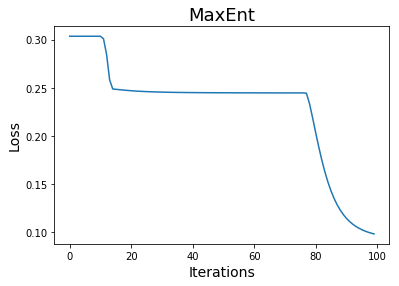

In [28]:
plt.plot(maxent_loss_history)
plt.title("MaxEnt")
plt.ylabel("Loss")
plt.xlabel("Iterations")

## With Error Fixed

In [29]:
R_model = Models.LinearRewardModel_ReLU(phi_dim, 0)
R_model.apply(weights_init)

# Optimizer
lr, weight_decay = 0.1, 1e-2
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)

In [30]:
maxent_loss_history, learned_policies, _, _ = MaxEntIRL(trajectory_list, lambda _: S, lambda _: T, A, phi, R_model, R_optimizer, gamma, 
                                                  verbose=True, debug=True, n_iters=100, boltzmann_temp=1.)

MaxEntIRL params 
-----
	 Domains: 2, sizes: [4, 4],
	 Action dim: 2, 
	 Feature dim: 4,
	 Iterations: 100, 
	 Max likelihood: 0.99,
	 VI iterations: 100, 
	 VI convergence eps: 0.001,
	 Gamma (discount factor): 0.99,
--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass didn't converge by 100.
Backward Pass Results: 
	Policy: [[0.93902075 0.06097929]
 [0.9660942  0.03390587]
 [0.9660942  0.03390587]
 [0.5        0.5       ]], 
	V: [6.146894 3.384167 3.384167 0.      ], 
	Q: [[6.0839763 3.349673 ]
 [3.349673  0.       ]
 [3.349673  0.       ]
 [0.        0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [9.4026023e-01 5.9050620e-02 0.0000000e+00 6.8918540e-04] 
	Diff: tensor([-0.6069,  0.1076,  0.1667,  0.3326]) 

Grads: 
	Param: 0, grad: tensor([[0., 0., 0., 0.]])
--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass didn't converge by 100.
Backward Pass Results: 
	Policy: [[0.93902075 0.06097929]
 [0.9660942  0.03390587]
 [0.9660942  0.03390587]
 [0.5        0.5       ]], 
	V: [6.146894 3.384167 3.384167 0.      ], 
	Q: [[6.0839763 3.349673 ]
 [3.349673  0.       ]
 [3.349673  0.       ]
 [0.        0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.166666


>>> Iter: 0014 (0.026s): loss = 00.248897, likelihood = 0.0000


--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-0.2432, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 94.
Backward Pass Results: 
	Policy: [[0.74898434 0.25101545]
 [0.9659436  0.03405649]
 [0.9659436  0.03405649]
 [0.5        0.5       ]], 
	V: [4.4841166 3.3797348 3.3797348 0.       ], 
	Q: [[4.1950793 3.1018758]
 [3.345085  0.       ]
 [3.345085  0.       ]
 [0.        0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.7699873  0.22716296 0.         0.00284957] 
	Diff: tensor([-0.4367, -0.0605,  0.1667,  0.3305]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.00

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.50112915 0.4916834  0.         0.00718746] 
	Diff: tensor([-0.1678, -0.3250,  0.1667,  0.3261]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.1678]])
--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-0.9704, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.36797893 0.63202107]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [2.831666  3.3779728 3.3779728 0.       ], 
	Q: [[1.8319364 2.3728335]
 [3.3432608 0.       ]
 [3.3432608 0.       ]
 [0.        0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.41173837 0.5791249  0.         0.00913671] 
	Diff: tensor([-0.0784, -0.4125,  0.1667,  0.3242]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.1568]])

>>> Iter: 0031 (0.024s): loss = 00.245432, likelihood = 0.0008


--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-1.6721, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.18418247 0.81581753]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [1.8747171 3.3779728 3.3779728 0.       ], 
	Q: [[0.18288872 1.6711526 ]
 [3.3432608  0.        ]
 [3.3432608  0.     

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.37853682 0.6114668  0.         0.00999643] 
	Diff: tensor([-0.0452, -0.4448,  0.1667,  0.3233]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.0452]])
--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.0975, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.1209754  0.8790246 ]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [1.3747526 3.3779728 3.3779728 0.       ], 
	Q: [[-0.7374154  1.2458103]
 [ 3.3432608  0.       ]
 [ 3.3432608  0.       ]
 [ 0.         0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.36670256 0.6229681  0.         0.01032936] 
	Diff: tensor([-0.0334, -0.4563,  0.1667,  0.3230]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.0667]])

>>> Iter: 0048 (0.025s): loss = 00.244835, likelihood = 0.0010


--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.4051, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.08924719 0.9107528 ]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [1.0316848 3.3779728 3.3779728 0.       ], 
	Q: [[-1.3846606   0.93820095]
 [ 3.3432608   0.        ]
 [ 3.3432608   0

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.0269]])
--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.5802, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.07505167 0.92494833]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [0.8410787 3.3779728 3.3779728 0.       ], 
	Q: [[-1.7484998  0.7630613]
 [ 3.3432608  0.       ]
 [ 3.3432608  0.       ]
 [ 0.         0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.36022815 0.6292532  0.         0.01051868] 
	Diff: tensor([-0.0269, -0.4626,  0.1667,  0.3228]) 

Grads: 
	Param: 0, grad: tensor([[

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.35706368 0.6323231  0.         0.01061323] 
	Diff: tensor([-0.0237, -0.4657,  0.1667,  0.3227]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.0475]])

>>> Iter: 0065 (0.026s): loss = 00.244693, likelihood = 0.0010


--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.7109, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.06594606 0.9340539 ]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [0.700537  3.3779728 3.3779728 0.       ], 
	Q: [[-2.018381   0.6323159]
 [ 3.3432608  0.       ]
 [ 3.3432608  0.    

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.35486785 0.6344525  0.         0.01067967] 
	Diff: tensor([-0.0215, -0.4678,  0.1667,  0.3227]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.0215]])
--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.7915, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.06089533 0.9391047 ]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [0.61460376 3.3779728  3.3779728  0.        ], 
	Q: [[-2.183995    0.55177546]
 [ 3.3432608   0.        ]
 [ 3.3432608   0.        ]
 [ 0.          0.        ]]

Loss: 
	Expert SVF: [0

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.35356233 0.6357183  0.         0.0107195 ] 
	Diff: tensor([-0.0202, -0.4691,  0.1667,  0.3226]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.0405]])

>>> Iter: 0082 (0.024s): loss = 00.244640, likelihood = 0.0010


--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.8578, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.05702923 0.9429707 ]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [0.54419893 3.3779728  3.3779728  0.        ], 
	Q: [[-2.3199923   0.48547888]
 [ 3.3432608   0.        ]
 [ 3.3432608

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.35250688 0.6367413  0.         0.01075188] 
	Diff: tensor([-0.0192, -0.4701,  0.1667,  0.3226]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000,  0.0000, -0.0192]])
--------------------------------------------------------------------------------
Backward Pass I/P: 
	S: [s: (1), s: (2), s: (3), s: (4)], 
	A: ['stay', 'move'], 
	R: [tensor(-2.9028, grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>), tensor(0., grad_fn=<SelectBackward>)], 
	T: <function T at 0x130f3a8c8>

Running Backward Pass  [ ... ] Backward pass converged @ 92.
Backward Pass Results: 
	Policy: [[0.05454545 0.9454546 ]
 [0.9658835  0.03411654]
 [0.9658835  0.03411654]
 [0.5        0.5       ]], 
	V: [0.496562  3.3779728 3.3779728 0.       ], 
	Q: [[-2.412159   0.4404726]
 [ 3.3432608  0.       ]
 [ 3.3432608  0.       ]
 [ 0.         0.       ]]

Loss: 
	Expert SVF: [0.33333333 0.

Loss: 
	Expert SVF: [0.33333333 0.16666667 0.16666667 0.33333333], 
	Learner SVF: [0.35180345 0.6372635  0.         0.01093312] 
	Diff: tensor([-0.0185, -0.4706,  0.1667,  0.3224]) 

Grads: 
	Param: 0, grad: tensor([[ 0.0000,  0.0000, -0.9412, -0.0369]])

>>> Iter: 0099 (0.024s): loss = 00.244533, likelihood = 0.0011




Text(0.5,0,'Iterations')

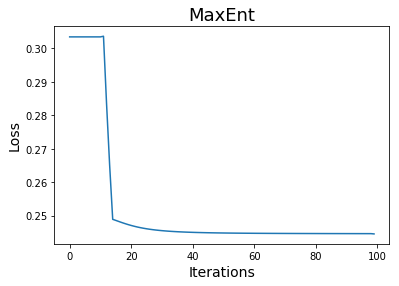

In [31]:
plt.plot(maxent_loss_history)
plt.title("MaxEnt")
plt.ylabel("Loss")
plt.xlabel("Iterations")